### Best viewed in [Jupyter Notebook viewer...](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/SBH_time_expressions.ipynb)
All references are in the works cited portion of the [readme](../readme.md).
<hr>

# Time Expressions in Genesis—Kings ("SBH")

In this notebook I aim to provide a simple overview of time expressions in the selected corpus of Genesis—Kings, the so-called Standard Biblical Hebrew texts (1). The ETCBC Hebrew database has a feature of `function` stored on phrases in the corpus. The primary function of interest here is `Time`. Thus, we begin with a basic exploratory overview of the ETCBC `Time` phrases, looking specifically at their identity and distribution.

*(1) The term 'Standard Biblical Hebrew' and the decision to limit the corpus is done only to give a firm starting point from which to analyze BH time phrases in the rest of the Hebrew Bible. It is thus not a stance on the ongoing debate about diachronic methods in Biblical Hebrew linguistics.*

In [1]:
# ETCBC's BHSA data
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa

# stats & data-containers
import collections
import pandas as pd
import numpy as np
import scipy.stats as stats

# data visualizations
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

In [2]:
# prep the data
name = 'time_expressions'
hebrew_data = ['~/github/etcbc/{}/tf/c'.format(direc) for direc in ('bhsa','lingo/heads', 'phono')] # data dirs
load_features = '''
heads prep_obj typ phono lex_utf8
''' 

# TF load statements
TF = Fabric(locations=hebrew_data, silent=True)
api = TF.load(load_features)
B = Bhsa(api=api, hoist=globals(), silent=True, name=name) # Bhsa functions for search and visualizing text

  0.00s loading features ...
   |     0.15s B lex_utf8             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.18s B phono                from /Users/cody/github/etcbc/phono/tf/c
   |     0.78s B heads                from /Users/cody/github/etcbc/lingo/heads/tf/c
   |     0.19s B prep_obj             from /Users/cody/github/etcbc/lingo/heads/tf/c
   |     0.19s B typ                  from /Users/cody/github/etcbc/bhsa/tf/c
  6.22s All features loaded/computed - for details use loadLog()


In [58]:
'''
Here are a set of counting and plotting functions
for easy searching and visualizing.
'''

def count_df(results, index, feature):
    '''
    Counts features of a TF search result list.
    Returns a dataframe with sorted counts.
    index = n of result; feature = feature string to call on n
    '''
    count = collections.Counter(Fs(feature).v(res[index]) for res in results)
    count_df = pd.DataFrame.from_dict(count, orient='index', columns=['count'])
    return count_df.sort_values(ascending=False, by='count')

def barplot_counts(count_df, title='', reverse_labels=False, size=(8, 6)):
    '''
    Makes simple barplot of sorted feature counts.
    '''
    n_bars = list(range(0, count_df.shape[0]))
    x_labels = [''.join(reversed(prep)) for prep in count_df.index] if reverse_labels else count_df.index
    plt.figure(figsize=size)
    sns.barplot(n_bars, count_df['count'].sort_values(ascending=False), palette='pastel')
    plt.xticks(n_bars, x_labels, size=18)
    plt.yticks(size=18)
    plt.title(title, size=18)
    plt.ylabel('count', size=18)
    plt.show()
    
def reverse_hb(hb_text):
    return ''.join(reversed(hb_text))

In [4]:
# prepare the corpus

corpus = [book for book in F.otype.s('book') if book < T.nodeFromSection(('Isaiah',))]
print('Corpus:\n')
print('\n'.join(T.sectionFromNode(book)[0] for book in corpus))

Corpus:

Genesis
Exodus
Leviticus
Numbers
Deuteronomy
Joshua
Judges
1_Samuel
2_Samuel
1_Kings
2_Kings


## Introductory Data Exploration

The `Time` feature is stored on phrases. What phrase types occur with these phrases, and in what quantity?

Number of time phrases in the corpus:
  0.30s 2180 results


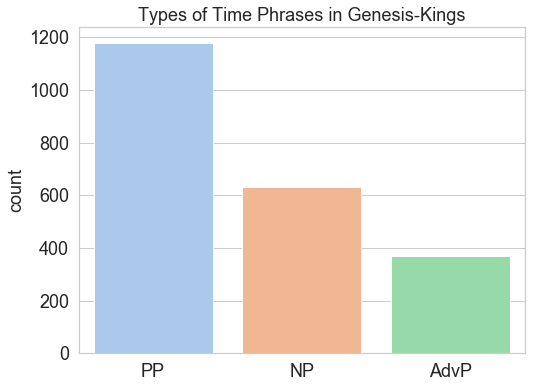


Phrase types and their frequency:


,count
PP,1180
NP,632
AdvP,368


In [5]:
find_time = '''
corpus
    phrase function=Time 
'''

# run the search, count features, and print/plot them
print('Number of time phrases in the corpus:')
times = B.search(find_time, sets={'corpus': corpus})
count_types = count_df(times, 1, 'typ')
barplot_counts(count_types, 'Types of Time Phrases in Genesis-Kings')
print('\nPhrase types and their frequency:')
count_types

The prepositional phrase is by far the most common in the corpus. We should thus have a look at the kinds of prepositions involved and their distributions.

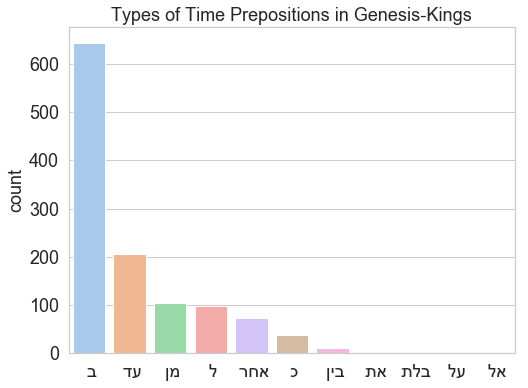



Prepositions and their frequency:



,count
ב,644
עד,205
מן,105
ל,99
אחר,74
כ,38
בין,10
את,2
בלת,1
על,1


In [6]:
'''
Count and plot the prepositions. For x-labels
the letter order has to be reversed 
in order to display properly in the plot
'''

prep_phrases = [res[1] for res in times if F.typ.v(res[1]) == 'PP']
prep_counts = collections.Counter(T.text(E.heads.f(pp)[0], fmt='lex-orig-plain') for pp in prep_phrases)
prep_counts = pd.DataFrame.from_dict(prep_counts, orient='index', columns=['count'])
prep_counts = prep_counts.sort_values(ascending=False, by='count')

barplot_counts(prep_counts, 'Types of Time Prepositions in Genesis-Kings', reverse_labels=True)
print('\n\nPrepositions and their frequency:\n')
prep_counts

### Preposition / Prepositional Object Attraction in Time Adverbials

Haspelmath describes the way in which certain prepositions paradigmatically combine with certain noun lemmas (1997: 102-107). For instance, in English there are different collocation preferences for 'on', as in "on Tuesday," and 'at', as in "at five o'clock." In this case 'on' prefers nouns referring to time spans whereas 'at' refers to points in time. Both prepositions illustrate the "simultaneous" function, which places a situation on or in a particular time reference.

Presumably Hebrew time adverbials would likewise exhibit attractional preferences between their prepositions and prepositional objects. We can measure these preferences by applying a measure of association, which tells how dependent two categorical variables are upon each other. First, one counts how many times each preposition occurs with any given noun. Those counts are then compared against all other counts and transformed into a number that reflects the significance of the relation. We can then display and plot the most attracted nouns to any given preposition.

Before we count the prepositions and their co-occurring nouns within time adverbials, we will look more closely at lowly-attested prepositional phrases. We see in the table above the prepositions בלת (usually "not"). Other prepositions with neglible counts include על, אל, and את. We retrieve those cases and look at them below.

In [7]:
low_attest_search = B.search('''

corpus
    phrase function=Time typ=PP
        -heads> word lex=BLT/|>L|<L|>T
''', sets={'corpus':corpus})

for result in low_attest_search:

    passage = '{} {}:{}'.format(*T.sectionFromNode(result[1]))
    preposition = F.lex_utf8.v(result[2])
    
    B.prettyTuple(result, condenseType='clause', seqNumber=f'{passage} ({preposition})')

  0.71s 6 results




**Result** *Genesis 21:26 (בלת)*





**Result** *Exodus 13:7 (את)*





**Result** *Deuteronomy 9:25 (את)*





**Result** *Deuteronomy 9:25 (את)*





**Result** *1_Samuel 25:8 (על)*





**Result** *2_Samuel 23:13 (אל)*



Note that for each result the "clause" can be clicked to pull up the full context.

#### בלת

This is an interesting case of what Waltke-O'Connor (WOC) call an "item adverb" (§39.3.1d), that is, the preposition בלת here modifies less the verbal argument (which already has לא) and more the object (the "item") of the preposition היום. Waltke-O'Connor list Hos 1:6 as an example, where the phrase לא רחמה appears.

### את

It is interesting that all uses of את with a time indicator occur alongside a niphal or hithpael. Typically את will mark the subject with these stems (WOC §10.3.2b). In Ex 13:7 מצות is the patient, so what role does את שבעת הימים play?

### אל and על

These two instances show something very interesting happening. The appearance of the verb בוא, in both cases, appears to have triggered the appearance of these prepositions. אל and על, as can be seen in the query below, occur much more frequently within locative phrases. And locative phrases are likely to co-occur with a verb such as בוא much more often. The result in 2 Sam 23:13 is especially fascinating, since it seems to juxtapose a time reference, a person reference, and a location reference. It is possible that in these instances the motion verb and preposition portray the subject as moving into or towards a point in time. This would be an example of what Haspelmath calls (via Clark 1973:50) the "moving-ego" model of time:

> It has often been observed that there are two ways in which time can be conceptualized in terms of movement: Either time is stationary, and the observer in the world moves through it, or the observer in the world is stationary and time moves past him or her. (1997: 59)

Both models are attested in language, though moving-time seems to be the most common (Haspelmath 1997: 60). Examples in English of the moving-ego model show up in "As we go through the years..." or "We're approaching the end of the year..." Even in these two examples, taken from Haspelmath, we can see the movement verb playing an important role. It is, thus, a reasonable question as to whether these constructions in the Hebrew Bible might convey a moving-ego sense of time.

#### Delineating a Test Set

We will set aside these four prepositions due to their rare usage and test the remaining seven prepositions for associated nouns. Below is a search template that finds results for the seven prepositions and their nouns. We add some important requirements, for instance that the object of the preposition must not be another preposition. This ensures that 

In [72]:
prep_obj_search = '''

corpus
    phrase function=Time typ=PP
        -heads> word lex=B|<D|MN|L|>XR/|K|BJN/
        -prep_obj> word pdp#prep ls#card|ppre lex#PNH/
'''

prep_obj_search = B.search(prep_obj_search, sets={'corpus':corpus})
print(f'\t{len(prep_phrases)-len(prep_obj_search)} PPs filtered out...')

  2.25s 1136 results
	44 PPs filtered out...


Thirteen prepositional phrases are filtered out either because they have another preposition as their object or they have a quantifier/potential preposition as their object.

<hr>

#### Excursus: What is the Typical Number of Prepositions inside Time Preposition Phrases?

N.B. the figures below include syndetic (with ו) prepositional phrases.

In [73]:
n_preps = collections.Counter()

for PP in prep_phrases:
    
    preps = [w for w in L.d(PP, 'word') if F.pdp.v(w) == 'prep']
    n_preps[len(preps)] += 1
    
n_preps.most_common()

[(1, 1052), (2, 108), (3, 16), (5, 2), (4, 2)]

<hr>

#### Making the Counts

In [74]:
prep_noun_counts = collections.defaultdict(lambda: collections.Counter())

for result in prep_obj_search:
    prep = F.lex_utf8.v(result[2])
    prep_obj = F.lex_utf8.v(result[3])
    prep_noun_counts[prep][prep_obj] += 1
    
prep_noun_counts = pd.DataFrame(prep_noun_counts).fillna(0)

prep_noun_counts.shape

(71, 7)

In [75]:
prep_noun_counts.head() # first five rows

,ב,ל,מן,אחר,עד,כ,בין
אבימלך,0.0,0.0,0.0,1.0,0.0,0.0,0.0
אור,0.0,0.0,0.0,0.0,2.0,0.0,0.0
אז,0.0,0.0,2.0,0.0,0.0,0.0,0.0
אחרון,2.0,1.0,0.0,0.0,0.0,0.0,0.0
אחרית,4.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Measure Associational Strength of the Counts

Because there are many zero counts in the table, a Fisher's Exact Test is the most appropriate (see Levshina, *How to do Linguistics with R*, 214). We also apply a log-transformation to convert p-values into negative/positive associations.

In [76]:
pp_noun_associations = collections.defaultdict(lambda: collections.Counter())

for target_pp in prep_noun_counts.columns:
    target_freq = prep_noun_counts[target_pp].sum()
    for colex in prep_noun_counts.index:
        colex_freq = prep_noun_counts.loc[colex].sum()
        
        # values for contingency table and expected freq.
        a = prep_noun_counts[target_pp][colex]
        b = target_freq - a
        c = colex_freq - a
        d = prep_noun_counts.sum().sum() - (a+b+c)
        
        # Fisher's
        contingency = np.matrix([[a, b], [c, d]])
        oddsratio, p_value = stats.fisher_exact(contingency)
        
        # log-transform if observed value below expected
        exp_f = (a+b) * (a+c) / (a+b+c+d) # expected freq.
        if a < exp_f:
            strength = np.log10(p_value)
        else:
            strength = -1 * np.log10(p_value)
            
        # save it
        pp_noun_associations[target_pp][colex] = strength
            
pp_noun_associations = pd.DataFrame(pp_noun_associations)

pp_noun_associations.head()

,ב,ל,מן,אחר,עד,כ,בין
אבימלך,-0.359897,0.000000,0.000000,1.262987,0.000000,0.0,0.0
אור,-0.720287,0.000000,0.000000,0.000000,1.463872,0.0,0.0
אז,-0.720287,0.000000,2.080504,0.000000,0.000000,0.0,0.0
אחרון,-0.000000,0.748383,0.000000,0.000000,0.000000,0.0,0.0
אחרית,0.865112,0.000000,0.000000,0.000000,0.000000,0.0,0.0


#### Display and Plot the Top Attracted Nouns per Preposition

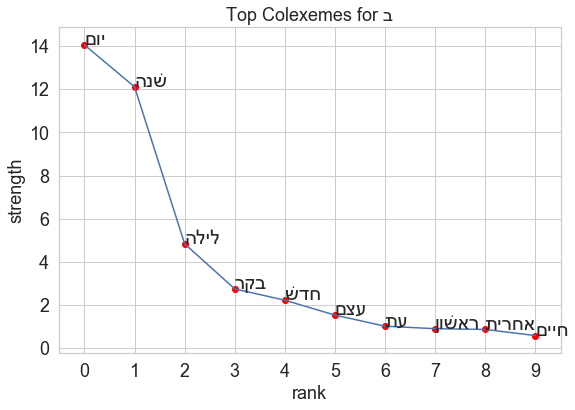

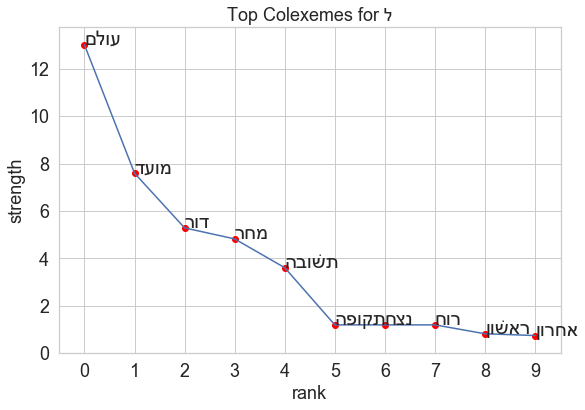

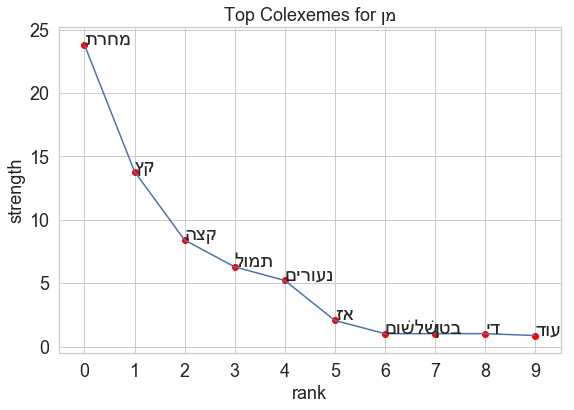

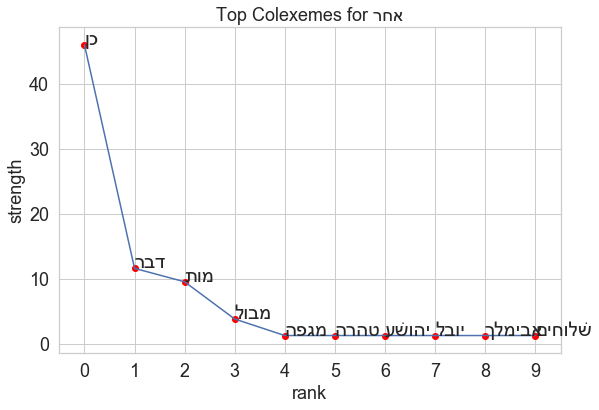

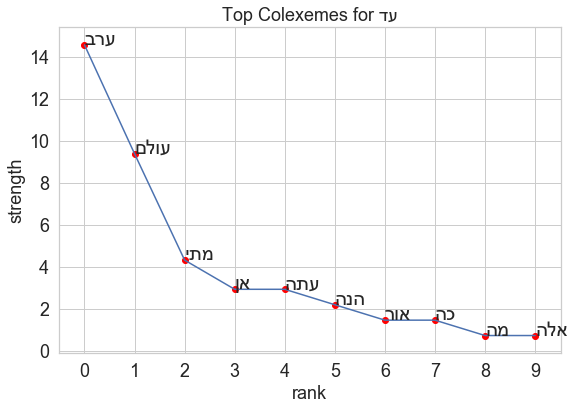

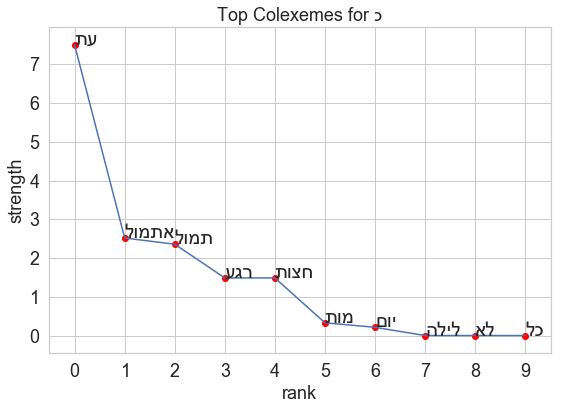

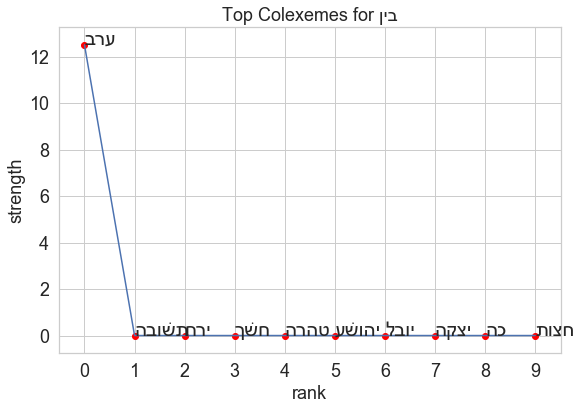

In [81]:
for prep in pp_noun_associations.columns:
    
    top_colex = pp_noun_associations[prep].sort_values(ascending=False).head(10)
    y = top_colex.values
    x = list(range(0, len(y)))
    labels = list(reverse_hb(colex) for colex in top_colex.index)

    plt.figure(figsize=(9, 6))
    plt.plot(x, y)
    plt.scatter(x, y, color='red')
    plt.title(f'Top Colexemes for {reverse_hb(prep)}', size=18)
    plt.yticks(size=18)
    plt.xticks(range(0, len(top_colex)), size=18)
    plt.xlabel('rank', size=18)
    plt.ylabel('strength', size=18)
    for x, y, label in zip(x, y, labels):
        plt.annotate(label, [x, y], size=20)

## Locative Phrases as a Comparison Point

**TO FIX: In the search template as-is, only adjunctive (i.e. "optional") uses of location are identified. This omits very important cases where location is indicated, such as with movement verbs. In these contexts, the location phrase is marked as a "complement". In order to rectify this, some cases of movement verbs and their complements might be added to the search template**

Haspelmath's *From Space to Time* (1997) proposes that time phrases share a genetic relationship with locative phrases. The idea is that locative phrases, which indicate location in three dimensional space, are metaphorically related to the two-dimensional time line (Haspelmath 1997: 21-24). Haspelmath finds this pattern across 53 world languages.

Comparing the structure of location constructions provides a helpful comparison point for time constructions. As will be shown, these two functions prefer different phrase types. The opportunity to explore and explain these differences helps show what is distinctive about the time adverbial. It could potentially also shed light about the role of time adverbials as clause constituents, especially as it pertains to the verb and its satellites.

The ETCBC stores location-indicating phrases under the function of `Loca`. In the query below, we extract those phrases, in addition to their head words and those head words' lexemes.

Number of Location phrases in Gen-Kgs:
  0.87s 1541 results


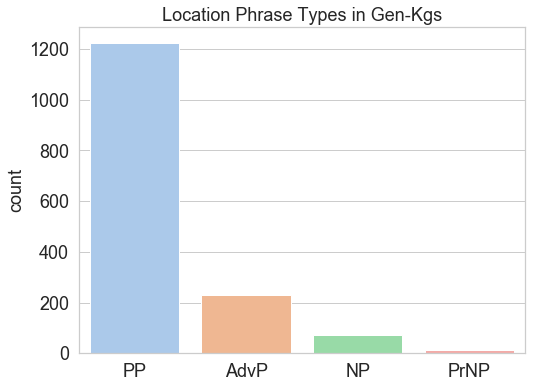

Location Phrase Type Counts in Gen-Kgs:


,count
PP,1225
AdvP,231
NP,73
PrNP,12


In [33]:
loca_phrases = '''
corpus
    p1:phrase function=Loca
        w1:word 
lex
   w2:word
   
p1 -heads> w1
w1 = w2
'''

print('Number of Location phrases in Gen-Kgs:')
locations = B.search(loca_phrases, sets={'corpus': corpus})
loca_counts = count_df(locations, 1, 'typ')
barplot_counts(loca_counts, 'Location Phrase Types in Gen-Kgs')
print('Location Phrase Type Counts in Gen-Kgs:')
loca_counts

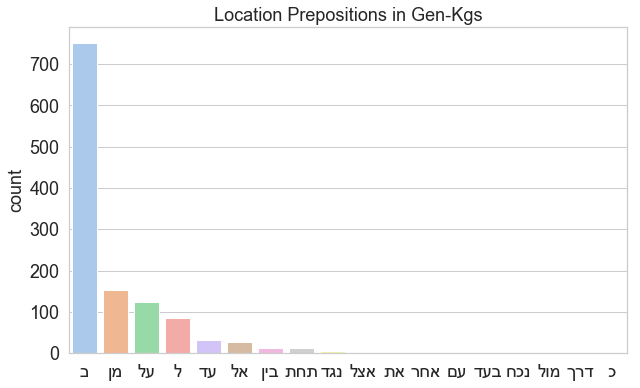

Location Preposition Counts in Gen-Kgs:


,count
ב,752
מן,153
על,123
ל,85
עד,33
אל,27
בין,14
תחת,14
נגד,6
אצל,4


In [34]:
loca_preps = count_df([res for res in locations if F.typ.v(res[1]) == 'PP'], 4, 'lex_utf8')
barplot_counts(loca_preps, 'Location Prepositions in Gen-Kgs', reverse_labels=True, size=(10, 6))
print('Location Preposition Counts in Gen-Kgs:')
loca_preps

We see here that Loca PPs have much more lexical diversity than the Time PPs. 

Below we make further comparisons between the Time and Loca phrases.

In [35]:
# compare location and time phrase types

loca_time = count_types.copy()
loca_time.columns = ['time']
loca_time = pd.concat([loca_time, loca_counts], axis=1, sort=True).fillna(0)
loca_time.columns = ['time', 'loca']
loca_time = loca_time

# normalize the counts
loca_time_norm = loca_time.apply(lambda column: column/column.sum()).sort_values(ascending=False, by='loca')

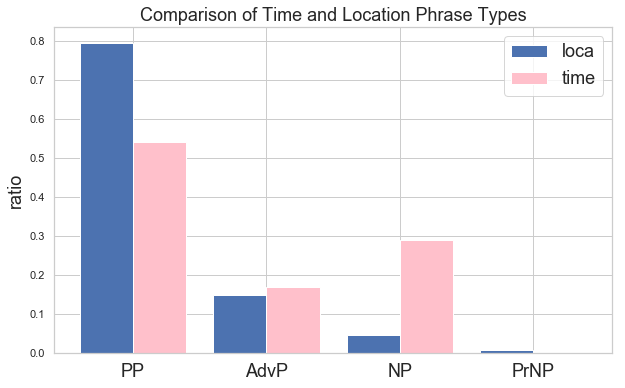


Normalized Ratios of Phrase Types for Time and Loca Function Phrases:


,time,loca
PP,0.541284,0.794938
AdvP,0.168807,0.149903
NP,0.289908,0.047372
PrNP,0.000000,0.007787


In [36]:
# make side-by-side bar charts

width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))   
bar_indices = np.arange(loca_time_norm.shape[0], step=1)
ax.bar(bar_indices, loca_time_norm['loca'], width, label='loca')
ax.bar(bar_indices+width, loca_time_norm['time'], width, label='time', color='pink')
ax.legend(fontsize=18)
ax.set_xticks(bar_indices+width/2)
ax.set_xticklabels(loca_time_norm.index, fontsize=18)
ax.set_ylabel('ratio', fontsize=18)
ax.set_title('Comparison of Time and Location Phrase Types', fontsize=18)
plt.show()
print('\nNormalized Ratios of Phrase Types for Time and Loca Function Phrases:')
loca_time_norm

In [37]:
print('Raw Counts of Phrase Types for Time and Loca Function Phrases:')
loca_time

Raw Counts of Phrase Types for Time and Loca Function Phrases:


,time,loca
AdvP,368.0,231
NP,632.0,73
PP,1180.0,1225
PrNP,0.0,12


Note the difference between the `Time` and `Loca` noun phrases (`NP`):

In [40]:
loca_time_norm['time']['NP'] - loca_time_norm['loca']['NP']

0.24253642041090917

There is also a slight decrease in `Time`'s preference of a prepositional phrase (`PP`):

In [41]:
loca_time_norm['time']['PP'] - loca_time_norm['loca']['PP']

-0.2536539480499378

Both `Loca` and `Time` are found often as prepositional phrases (`PP`). But `Time` is found as a simple noun phrase (`NP`) much more often (+0.24). This results in a lower ratio of prepositional phrases for `Time` (-0.25). Thus, the bare noun phrase appears to play a more important role in the `Time` function.

Surprisingly, `Time` and `Loca` share a fairly equal preference for the adverb phrase (`AdvP`) at 0.17 and 0.15, respectively. It is not surprising, on the other hand, that `Time` does not appear in a proper noun phrase `PrNP`, since time units do not generally have proper names (with the exception of something like seasons or festivals). 

#### Testing for Association Strengths

We have observed that there are higher levels of NP in `Time` function phrases than in `Loca` phrases. We have also seen a decrease in the ration of `NP` phrases used with `Time`. Are these differences statistically significant?

In [38]:
loca_time_fish = collections.defaultdict(lambda: collections.defaultdict())

for funct_i in loca_time.columns:
    total_i = loca_time[funct_i].sum() # for req value
    
    for typ_j in loca_time.index:
        total_j = loca_time.loc[typ_j].sum() # for req value
        
        # get values for fisher's exact test and run the test
        a = loca_time[funct_i].loc[typ_j] # observed freq
        b = total_i - a
        c = total_j - a
        d = loca_time.sum().sum() - (a+b+c)
        contingency = np.matrix([[a, b], [c, d]])
        oddsratio, p_value = stats.fisher_exact(contingency)
        loca_time_fish[funct_i][typ_j] = round(p_value, 5)
        
loca_time_fish = pd.DataFrame(loca_time_fish)
loca_time_fish

,time,loca
AdvP,0.12393,0.12393
NP,0.00000,0.00000
PP,0.00000,0.00000
PrNP,0.00002,0.00002


Any value < 0.05 represents a statistically significant association between the two categories (more specifically, these are cases where there is <5% chance that the observed values are due to chance; the null hypothesis, which states that the observed value is not due to a categorical association, can be rejected on a value <0.05). Thus, we can see that the values for `NP` and `PP` are significantly associated with `Time` and `Loca`, with lower values for `NP` x `Time` and higher values for `PP` x `Time`. The proper noun phrase (`PrNP`) is also associated strongly, negatively so with `Time` and positively so with `Loca`. This makes sense, since most time phrases in the HB will not have a proper noun. The `AdvP`, as we observed with the ratios, is not associated with either `Time` or `Loca`, since these two categories have a nearly equal proportion of this phrase type.